# CNN을 이용한 이미지 인식 아이디어
- 시각 피질 작동 원리 : 1950년대
  - 시각 인지 과정
    - 계층적으로 일어난다.
    - 눈의 앞 층에 존재하는 세포들이 이미지의 극히 일부분만 인식
    - 이런 데이터들이 모여서 하나의 이미지로 인식
    - 뒤로 갈수록(뒤쪽에 있는 세포들은) 더 큰 이미지를 인지한다.    
  - 시각 피질 내의 여러 세포들은 각자 부분을 인지
    - 지형학적인 매핑 과정이 존재

- 1980년대 경사 하강법이 학습 가능한 합성곱 네트워크(CNN) 기반으로 만든 LeNet 모델에 성공적으로 적용되서 숫자 코드 인식에 성공   
- 2012년 AlexNet에서 최초 CNN 모델을 적용하여 이것이 이미지 인식의 표준이 되는 사건이 발생

# 이미지 데이터 
- 수치로 구성
- 구성 shape 
  - 높이 : 세로 길이의 픽셀 수
  - 너비 : 가로 길이의 픽셀 수
  - 채널 : 색의 성분
    - 흑백 : 채널이 1개, 픽셀 한개는 0~255(1 unsigned byte) : 0 ~ 2^n - 1 (n = 8)
    - 칼라 : 채널이 3개, Red, Green, Blue 조합
- 3D, 큐브, 3차 행렬
  - [ n개의이미지, h, w, 채널수(1 or 3) ]
    or
    [ n개의이미지, 채널수(1 or 3), h, w ]
- Pillow 활용
  - 이미지를 화면에 보이게 처리하는 모듈로 사용
  - JPEG, BPM, GIF, PNG, PPM, TIFF등 지원    


# 이미지 확인

- 칼라, 흑백 이미지 비교

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

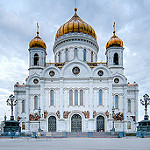

In [13]:
# 이미지 원본 로드
img = Image.open('/content/8.cnn_building.jpg')
img

In [15]:
# 컬러 이미지를 배열화 처리
import numpy as np

np.array(img).shape, img.size

# 이미지를 배열로 뽑아보니 [height, width, channels] 성립

((150, 150, 3), (150, 150))

In [16]:
# 흑백 이미지로 변환해서 확인
img = img.convert('L')
np.array(img).shape, img.size

((150, 150), (150, 150))

# 이미지를 텐서로 변환

-  이미지 원본 -> Image -> ndarray -> Tensor

In [0]:
import torch

In [45]:
img_tensor = torch.Tensor(np.array(img))
img_tensor, img_tensor.size()

(tensor([[212., 213., 215.,  ..., 197., 199., 200.],
         [215., 216., 216.,  ..., 197., 199., 200.],
         [213., 214., 215.,  ..., 196., 197., 198.],
         ...,
         [170., 170., 171.,  ..., 163., 166., 161.],
         [174., 174., 174.,  ..., 172., 174., 167.],
         [168., 168., 168.,  ..., 157., 158., 149.]]), torch.Size([150, 150]))

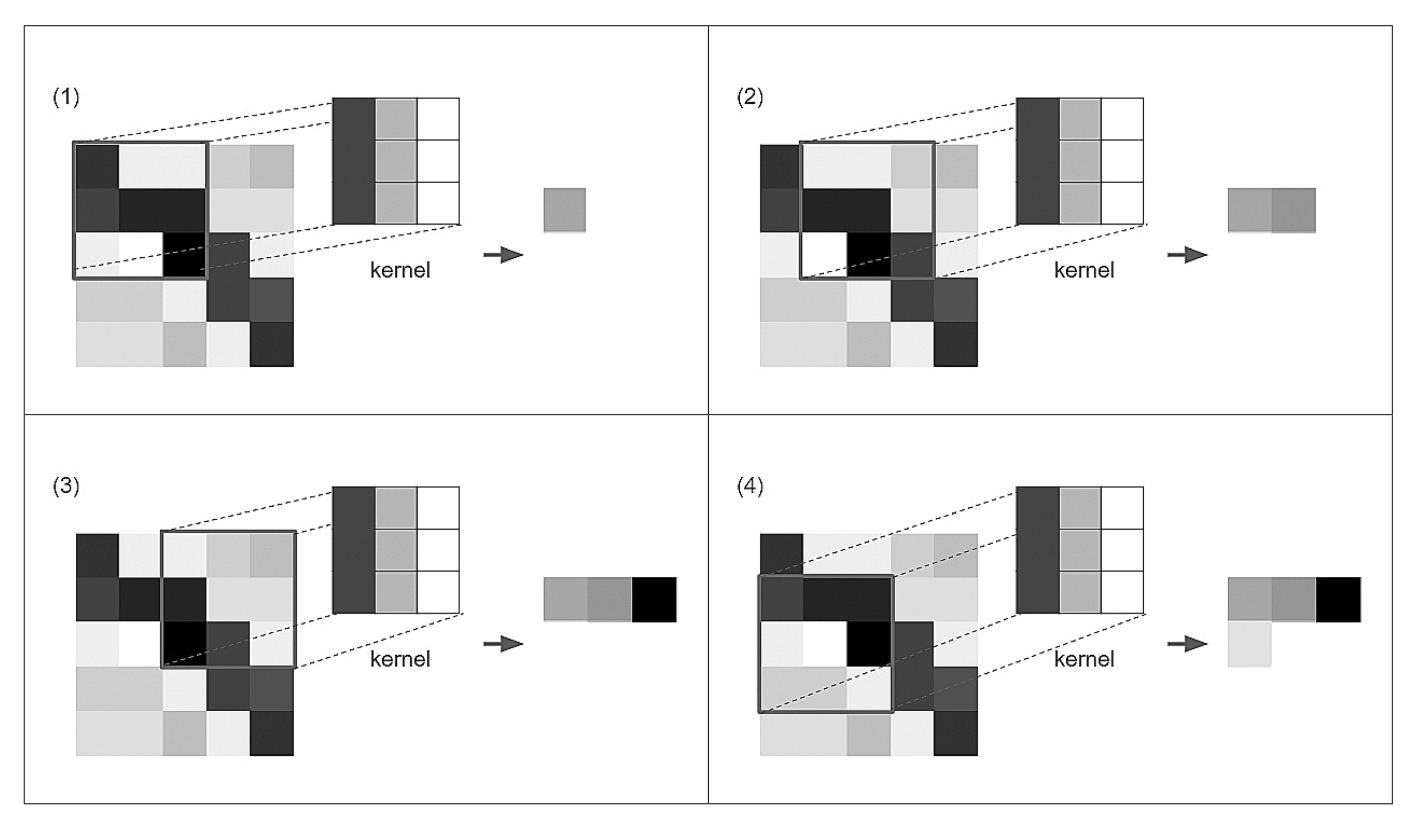

In [47]:
from IPython.display import  Image as IM

IM('/content/8.합성곱연산_모서리탐지.jpeg', width=500)

# 커널의 값의 배치, 값 자체에 의해서 이미지 원본이 스트라이드 후 나온 결과로
# 다양하게 이미지를 변화시킨다. -> 이미지의 특징을 추출하는 것과 동일하다.
# 커널의 공유 파라미터(= w)에 의해서 특징은 다양하게 추출될 수 있다.

- 이미지 원본 5x5x1(높이x가로x채널수)
- 커널(= 필터)가 전체 이미지를 처음부터 끝까지 스캔(필터링, 특징을 추출한다.)
- 커널 크기 3x3
- 스트라이드는 가로1, 세로1
- 이미지 원본을 커널이 스캔하는 총 회수 = 9회
    - (5-3+1)(5-3+1) = 3 3 = 9회

In [5]:
# 이미지 더미 데이터
# (5, 5)
tmp = np.array([[13, 1, 2, 3, 4], 
                [12, 14, 14, 2, 2],
                [1, 0, 16, 12, 1],
                [3, 3, 1, 12, 11],
                [2, 2, 4, 2, 13]])

ex_img_tensor = torch.Tensor( tmp )
ex_img_tensor

tensor([[13.,  1.,  2.,  3.,  4.],
        [12., 14., 14.,  2.,  2.],
        [ 1.,  0., 16., 12.,  1.],
        [ 3.,  3.,  1., 12., 11.],
        [ 2.,  2.,  4.,  2., 13.]])

In [0]:
# 커널
# (3, 3)
# 아래 같은 값(w)을 가진 커널을 수직 커널, 수직 탐색 커널
kernel = torch.Tensor([[1, 0, -1], 
                       [1, 0, -1], 
                       [1, 0, -1]])

In [0]:
# 합성곱 연산 처리 함수 직접 구현
# (X = 이미지 원본, kernel)
def convolution_operation(X, kernel):

    # 이미지의 높이, 너비 획득
    height, width = X.size()
    print(X.size(), height, width, kernel.size(0), kernel.size(1))

    # 커널 사이즈(정사각형이어서 한 개만 구한다.)
    kernel_size = kernel.size(0)

    # 합성곱 연산 결과를 담을 리스트
    tmp = list()

    for i in range(height - kernel_size + 1):       # 높이 기준으로 계산, 세로로 3번 스캔
        for j in range(width - kernel_size + 1):    # 너비 기준으로 계산, 가로로 3번 스캔
            
            # 원본을 자른다.
            # X[i:i + kernel_size, j:j + kernel_size]

            # 원본과 커널을 곱한다.
            # X[i:i + kernel_size, j:j + kernel_size] * kernel

            # 원소들을 다 합해서 하나의 값으로 수렴 -> sum
            tmp.append(torch.sum(X[i:i + kernel_size, j:j + kernel_size] * kernel))

    # 컨볼루션 텐서를 반환
    convs = torch.Tensor(tmp)

    return convs

In [55]:
convs = convolution_operation(ex_img_tensor, kernel).view(3, 3)

torch.Size([5, 5]) 5 5 3 3


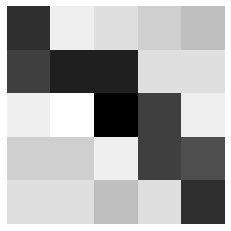

In [57]:
# 원본 드로잉
fig, axes = plt.subplots(1, 1)
axes.matshow(ex_img_tensor, cmap='binary')
axes.axis('off')    # 좌표축 값 생략
plt.show()

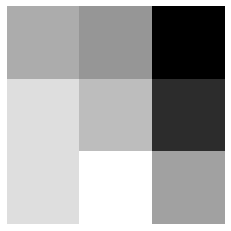

In [58]:
# 필터를 통과한 데이터 드로잉
fig, axes = plt.subplots(1, 1)
axes.matshow(np.array(convs), cmap='binary')
axes.axis('off')
plt.show()

In [0]:
# 수직선 탐지 커널
vertical_kernel = torch.Tensor([[1, 0, -1], 
                                [1, 0, -1], 
                                [1, 0, -1]])

In [0]:
# 수평선 탐지 커널
horizontal_kernel = torch.Tensor([[1, 1, 1], 
                                  [0, 0, 0], 
                                  [-1, -1, -1]])

In [65]:
v_conv = convolution_operation(ex_img_tensor, vertical_kernel).view(3, 3)

torch.Size([5, 5]) 5 5 3 3


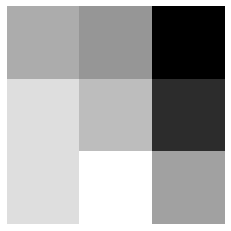

In [66]:
fig, axes = plt.subplots(1, 1)
axes.matshow(np.array(v_convs), cmap='binary')
axes.axis('off')
plt.show()

In [67]:
h_conv = convolution_operation(ex_img_tensor, horizontal_kernel).view(3, 3)

torch.Size([5, 5]) 5 5 3 3


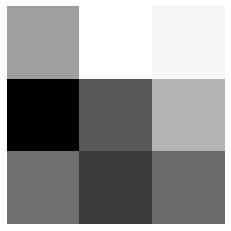

In [68]:
fig, axes = plt.subplots(1, 1)
axes.matshow(np.array(h_convs), cmap='binary')
axes.axis('off')
plt.show()

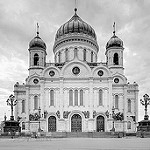

In [69]:
# 아래 이미지를 수직탐지커널, 수평탐지커널을 이용하여 확인
img

In [70]:
img_tensor

tensor([[212., 213., 215.,  ..., 197., 199., 200.],
        [215., 216., 216.,  ..., 197., 199., 200.],
        [213., 214., 215.,  ..., 196., 197., 198.],
        ...,
        [170., 170., 171.,  ..., 163., 166., 161.],
        [174., 174., 174.,  ..., 172., 174., 167.],
        [168., 168., 168.,  ..., 157., 158., 149.]])

In [0]:
def convolution_operationEx(X, kernel):
    height, width = X.size()
    kernel_size = kernel.size(0)

    tmp = list()

    # 커널을 통과한 데이터를 2차원으로 처리 [[], []]
    for i in range(height - kernel_size + 1):
        tmp.append([torch.sum(X[i:i + kernel_size, j:j + kernel_size] * kernel)
                    for j in range(width - kernel_size + 1)])

    convs = torch.Tensor(tmp)

    return convs

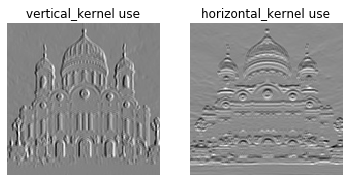

In [74]:
# 원본 이미지에 커널을 통과시켜서 나온 텐서
v_conv = convolution_operationEx(img_tensor, vertical_kernel)
h_conv = convolution_operationEx(img_tensor, horizontal_kernel)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(np.array(v_conv), cmap='binary')
ax1.axis('off')
ax1.set_title('vertical_kernel use')

ax2.imshow(np.array(h_conv), cmap='binary')
ax2.axis('off')
ax2.set_title('horizontal_kernel use')

plt.show()

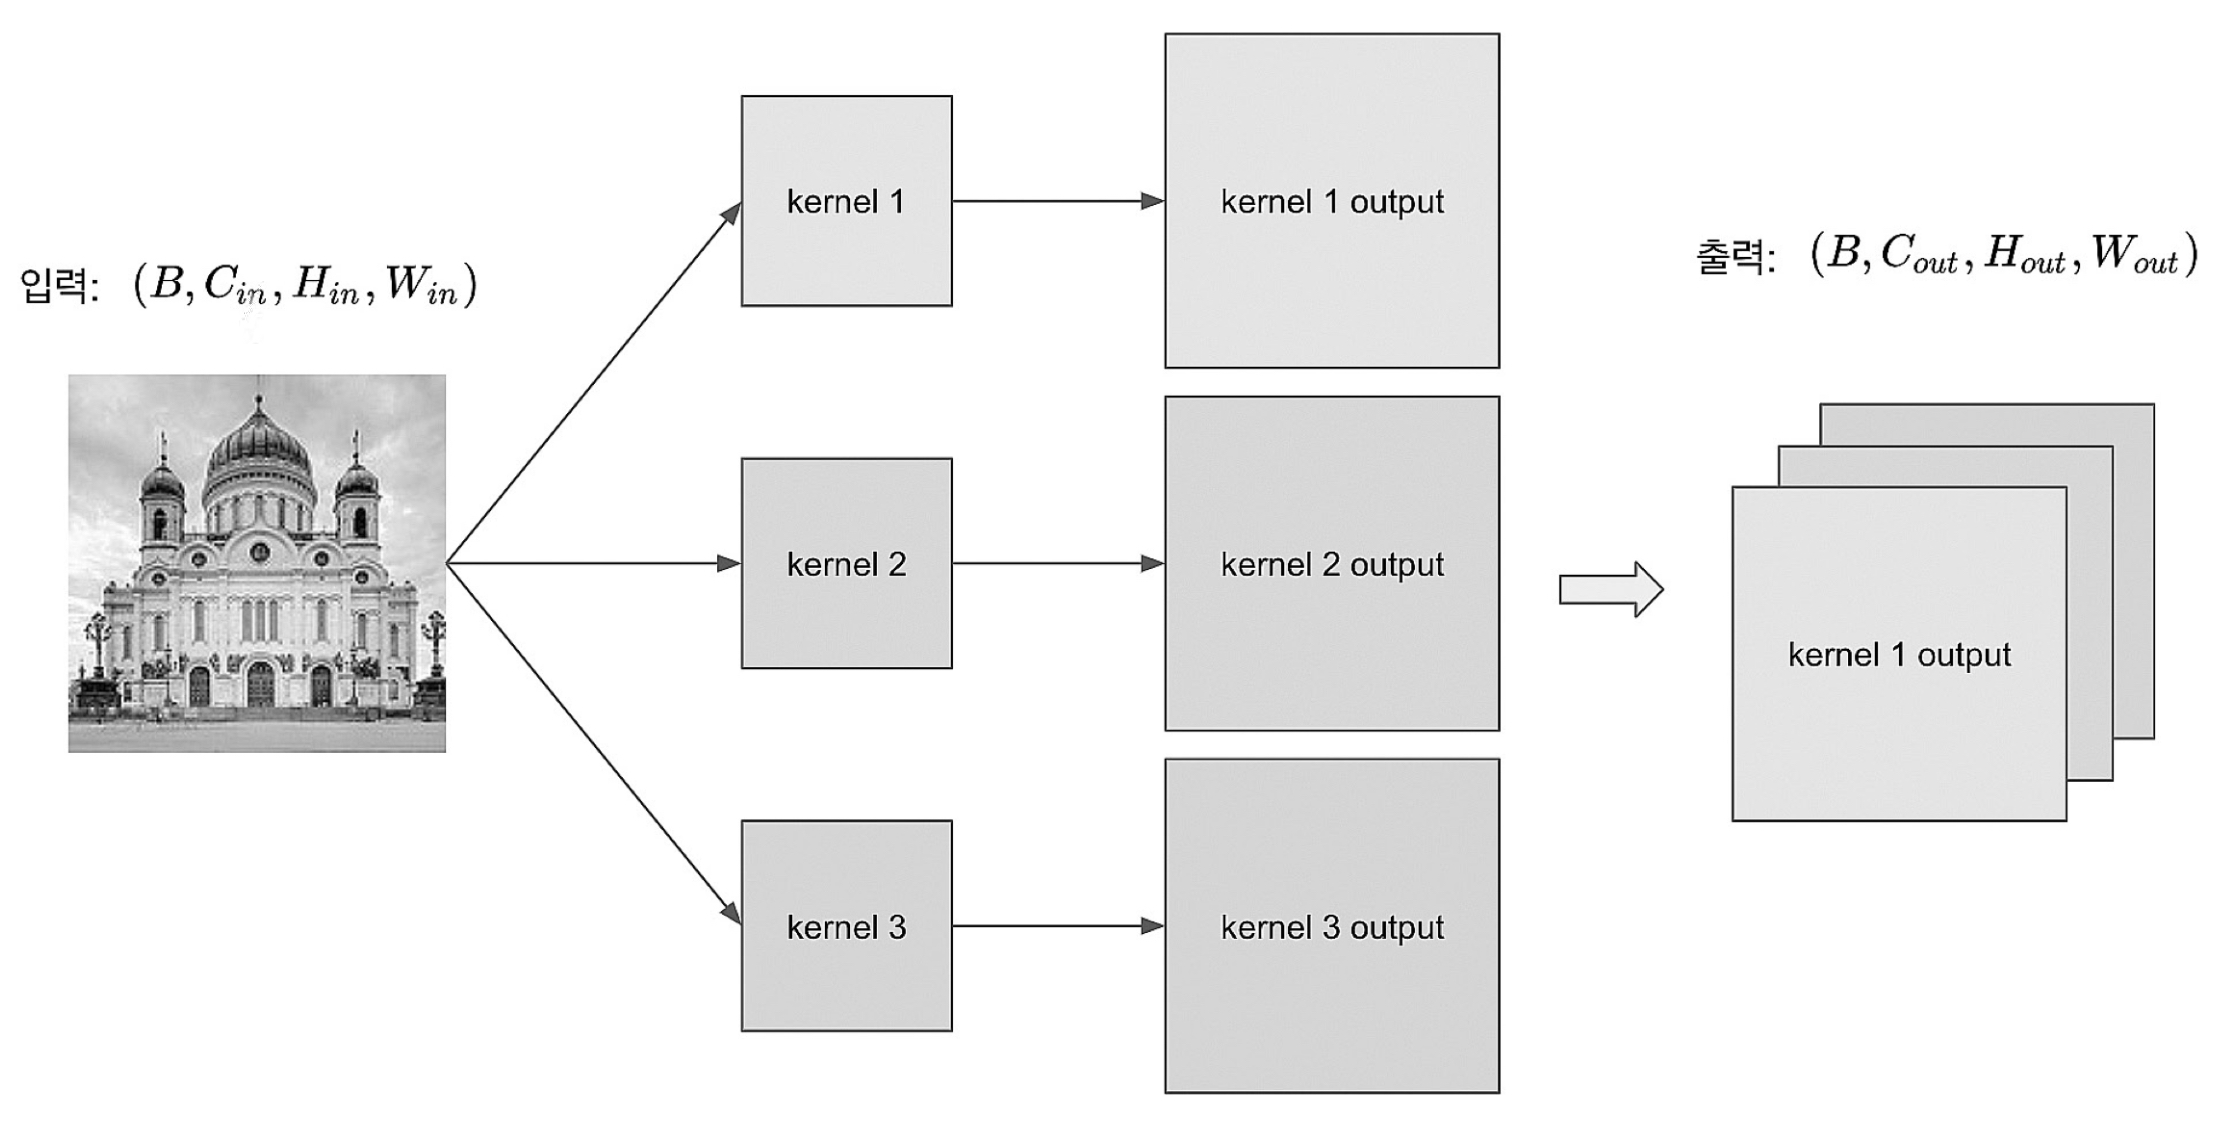

In [75]:
IM('/content/8.이미지처리.jpeg', width=500)

# 합성곱층

- 그림 설명
    - B : 배치 사이즈, 이미지 개수
    - C : 채널
    - H : 이미지 높이
    - W : 이미지 너비
    - 내용
        - 이미지 원본에 출력 채널만큼 설정한 수 만큼 커널을 준비하여, 원본을 통과시켜 출력 채널 수 만큼 이미지가 생성된다.(이미지 한 개에 출력 채널 수 만큼 설명할 수 있게 만들어진다.)
        - 이미지 하나를 설명하는데 출력 채널 수 만큼의 설명 내용이 발생한다. 

- 공식
    - P : 패딩, S : 스트라이드, K : 커널크기
    - H : 이미지 높이, W : 이미지 너비
    - H(out) = ((H(in) + 2*P - K)/S) + 1
        - 더미 데이터로 계산 : (5 + 2*0 - 1)/1) + 1 = 3
    - W(out) = ((W(in) + 2*P - K)/S) + 1
        - 더미 데이터로 계산 : (5 + 2*0 - 1)/1) + 1 = 3
- 원본이미지(타지마할)
    - (150 + 2*0 - 3)/1) + 1 = 148

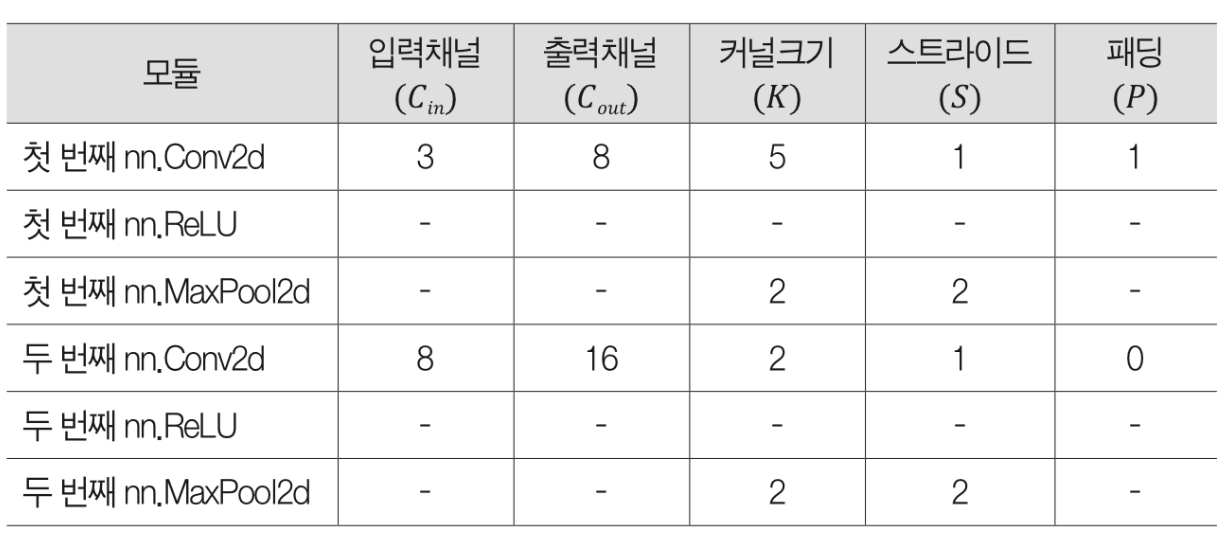

In [78]:
IM('/content/8.cnn_value.jpeg', width=500)

# 레이어를 설계할 때 수치의 변화를 잘 계산해서 채널 수를 지정
# 채널의 값에 따라 성능이 달라지니 잘 검토

## 합성곱층 API

- torch.nn.Conv2d

In [79]:
h, w = img_tensor.size()
h, w

(150, 150)

In [80]:
# img_tensor -> shape 확장 -> [batch, channel, h, w]
# 차원확장 expand()
img_tensor = img_tensor.expand(1, 1, h, w)
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [81]:
# 합성곱층을 만들기 위한 수치 정보 준비
batch, in_channels, height, weight = img_tensor.size()

# 출력채널, 커널사이즈, 스프라이드
out_channels = 1
kernel_size = 3
stride = 1

batch, in_channels, height, weight, out_channels, kernel_size, stride

(1, 1, 150, 150, 1, 3, 1)

In [0]:
# 위에서 직접 만든 컨볼루션 함수와 동일 결과를 내기 위해서 조정
conv_layer = torch.nn.Conv2d(in_channels=in_channels, 
                             out_channels=out_channels, 
                             kernel_size=kernel_size, 
                             stride=stride,
                             bias=False)

In [83]:
conv_layer, type(conv_layer)

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False),
 torch.nn.modules.conv.Conv2d)

In [85]:
# 만들어진 합성곱 레이어에 커널값(가중치, w, 공용파라미터) 부여
# 이미 값이 설정되어 있다.(기본 설정, 난수)
conv_layer.weight.data, conv_layer.weight.data.size()

(tensor([[[[-0.2129,  0.0566, -0.1608],
           [-0.1214,  0.0004, -0.1444],
           [ 0.1051,  0.2562, -0.3223]]]]), torch.Size([1, 1, 3, 3]))

In [86]:
# 자동으로 생성되는 커널의 shape이 4D이므로, 수직커널도 확장해준다.
# 합성곱층에 커널값을 교체
conv_layer.weight.data = vertical_kernel.expand(1, 1, kernel_size, kernel_size)
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

- 기존 제공 API에 함수 torch.nn.Conv2d를 우리가 직접 만든 함수와 동일한 효과를 내는지 검증하기 위해서 조건들을 부여하여 생성했다.
- 합성곱층을 통과시켜서 나온 결과를 시각화 했을 때, 결과물이 동일하면 동일한 성능을 내는 합성곱층 함수라고 판단할 수 있다.

In [87]:
convs = conv_layer(img_tensor)
convs.size()

torch.Size([1, 1, 148, 148])

In [89]:
# [1, 1, 148, 148] -> [148, 148]
convs.squeeze().size()

torch.Size([148, 148])

In [90]:
# 현재 텐서 상의 그래프를 분리하여 새롭게 획득
convs.squeeze().detach().size()

torch.Size([148, 148])

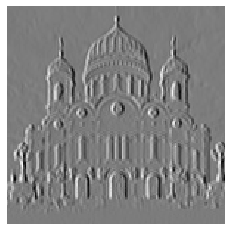

In [91]:
# 시각화하여 확인
plt.imshow(convs.squeeze().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [92]:
convs.squeeze().detach()

# 필터에 포함되어 있는 -1 값 때문에 데이터에 음수가 많이 포함되어 있다.
# 음수값들을 처리해야 보다 경계선(외곽선)이 명확해지고 -> 특징을 더욱 강화할 수 있다.

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -3.,   0.,  ...,  -7.,  -7.,  -4.],
        [-10., -10.,  -7.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [93]:
# ReLu 활성화 함수 통과 -> 최종적인 합성곱층이 완성
activation_map = torch.relu(convs)
activation_map

tensor([[[[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          ...,
          [ 0.,  1.,  2.,  ...,  2.,  0.,  5.],
          [ 0.,  0.,  0.,  ...,  4.,  2.,  8.],
          [ 0.,  0.,  0.,  ...,  4.,  6., 15.]]]], grad_fn=<ReluBackward0>)

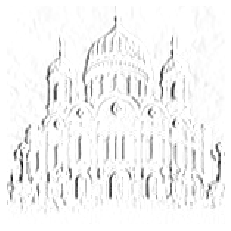

In [94]:
# cmap을 gray에서 binary로 변경 처리(0 이 많아져서, gray하면 거의 검게 나온다.)
plt.imshow(activation_map.squeeze().detach().numpy(), cmap='binary')
plt.axis('off')
plt.show()

# 풀링층

## 풀링층 직접 구현

- 합성곱층을 통과한 활성화 맵의 값을 강화한다.
- 특징을 강화한다.
- 이미지의 크기를 줄여서 연산 속도를 높인다.

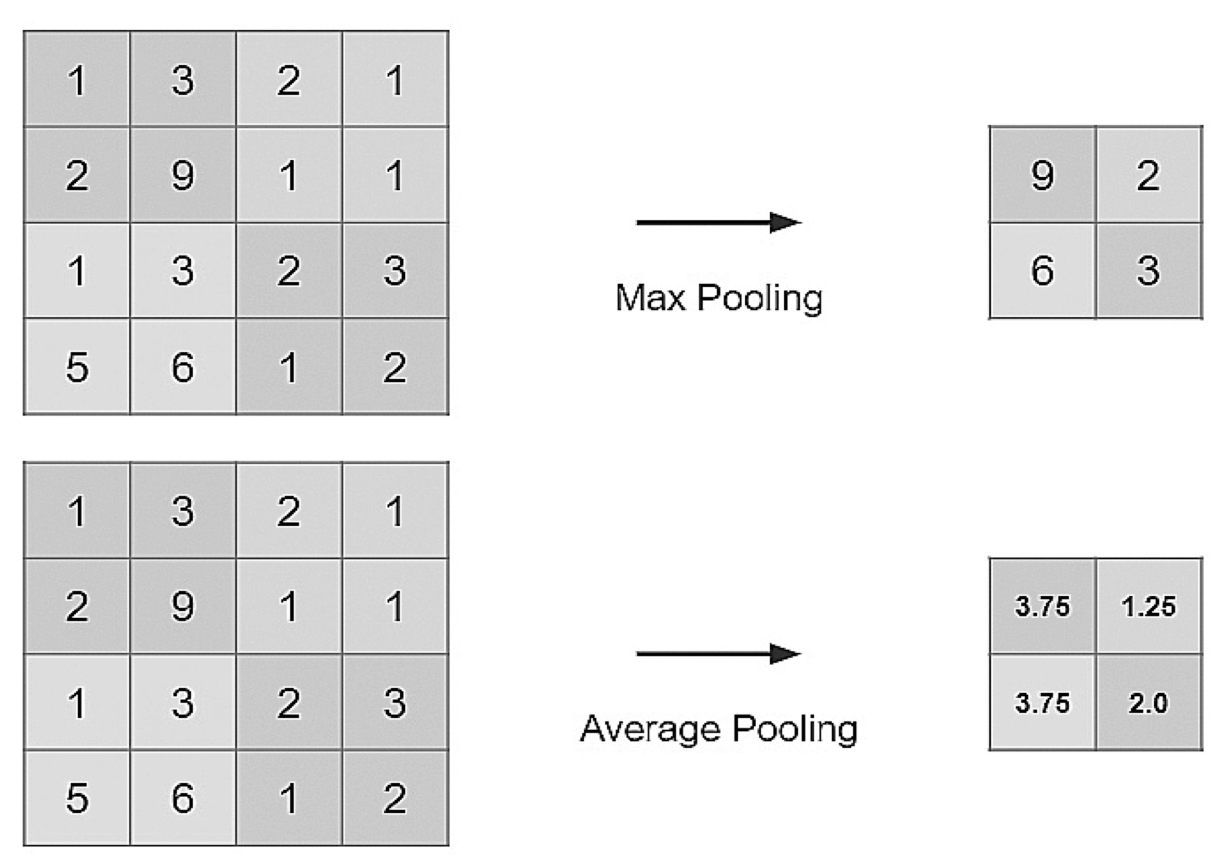

In [97]:
IM('/content/8.pooling.jpeg', width=400)

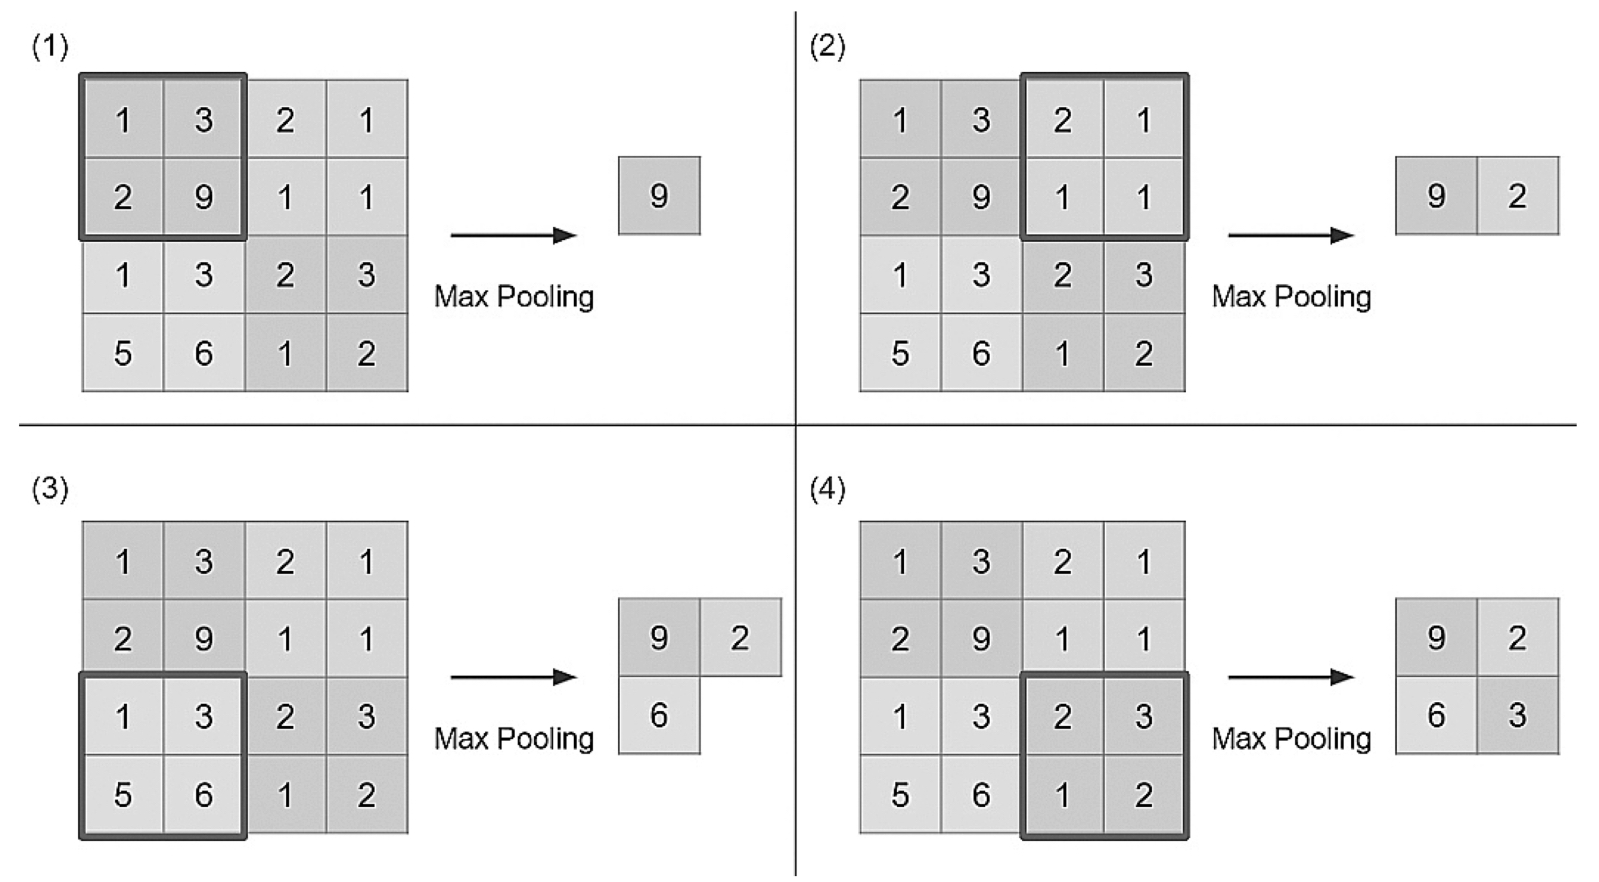

In [99]:
IM('/content/8.pooling2.jpeg', width=500)

In [100]:
# 이전 계층의 결과물
b, c, h, w = activation_map.size()
b, c, h, w

(1, 1, 148, 148)

In [0]:
# 커널 사이즈 설정
kernel_size = 2

In [102]:
# 세 번째 차원의 인덱스 번호 2에 대해 풀링 처리하고, 뒤에 stride의 크기를 추가한 형태
activation_map.unfold(2, kernel_size, kernel_size).size()

torch.Size([1, 1, 74, 148, 2])

In [103]:
activation_map.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size).size()

torch.Size([1, 1, 74, 74, 2, 2])

In [106]:
# 이렇게 만들어진 텐서에서 추가된 부분에서 최대값을 취한다.
# maxpool 완성
activation_map.unfold(2, kernel_size, kernel_size) \
                .unfold(3, kernel_size, kernel_size).max(-1)[0].max(-1)[0].size()

torch.Size([1, 1, 74, 74])

In [0]:
# 실 구현
def maxpooling(X, kernel_size, stride=None):
    assert X.ndimension() == 4, '오직 4-d 만 지원한다.'

    # 스트라이드
    if not stride:  # stride가 없다면
        stride = kernel_size 

    # 입력 데이터의 정보
    b, c, h, w = X.size()

    # maxpooling
    m = X.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride).max(-1)[0].max(-1)[0].size()

    return m

In [110]:
maxpools = maxpooling(activation_map, kernel_size=2)
maxpools

torch.Size([1, 1, 74, 74])

## 풀링층 API

In [0]:
maxpool_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2)

In [0]:
# 최대 풀링층에 이전 단계 활성화맵을 대입
mps = maxpool_layer(activation_map)
mps.size()

# 수식에 의해서 계산해봐도 74가 나온다.
# (148 + 2*0 - 2)/2) + 1 = 74

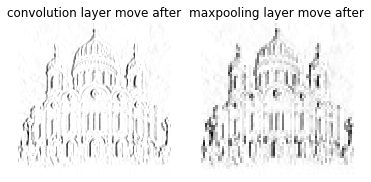

In [118]:
# 풀링층을 통과한 데이터의 시각화
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(activation_map.squeeze().detach().numpy(), cmap='binary')
ax1.axis('off')
ax1.set_title('convolution layer move after')

ax2.imshow(mps.squeeze().detach().numpy(), cmap='binary')
ax2.axis('off')
ax2.set_title('maxpooling layer move after')

plt.show()